# COSC325 Final Project
## FraudBot
#### Ryan Franqui, Blake Milstead, Karim Chmayssani

In [21]:
!nvidia-smi

Mon Nov 25 19:34:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
RANDOM_STATE = 42

### Visualizing the Dataset

In [24]:
url = 'https://raw.githubusercontent.com/BlakeMilstead/FraudBot/refs/heads/main/fraud_data.csv'
data = pd.read_csv(url)
y = data['is_fraud']

# we found 2 data points with incorrect formatting, so here we remove those rows
err_y = [y.unique()[1], y.unique()[3]]
data = data[~data['is_fraud'].isin(err_y)].reset_index(drop=True)
y = data['is_fraud'].astype(int)

dob = data['dob']

dob_clean = []
for i in range(len(data)):
    dob_clean.append(int(dob[i][-4:]))

data = data.assign(dob_clean = dob_clean)

data.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,dob_clean
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1,1939
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1,1939
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1,1939
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1,1939
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1,1939


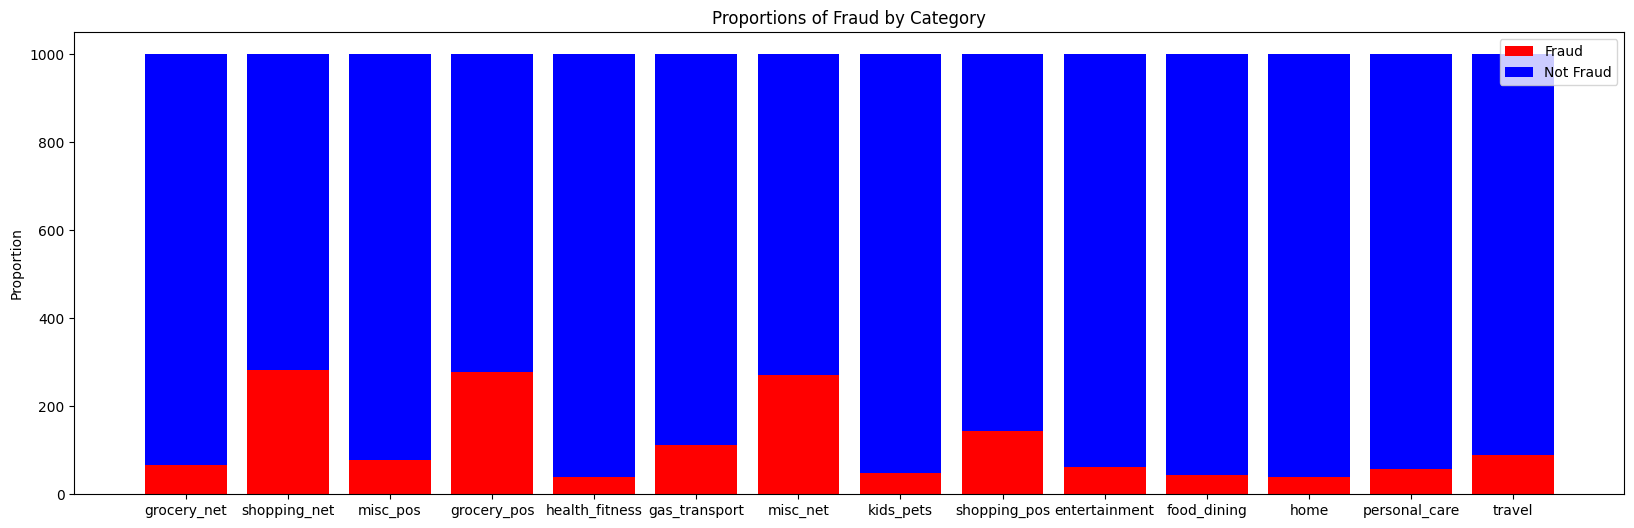

In [25]:
categories = data['category'].unique()

c_data = [data[data.category == category].reset_index(drop=True) for category in categories]

c_vals = np.array([c_data[i].shape[0] for i in range(0, len(categories))])

frauds_by_cat = []
for i in range(len(categories)):
    is_fraud = np.array([c_data[i].is_fraud[j] for j in range(c_vals[i])], dtype=int)
    n_frauds = np.sum(is_fraud)
    frauds_by_cat.append(n_frauds)
frauds_by_cat = np.array(frauds_by_cat)
fraud_prop_by_cat = frauds_by_cat / c_vals

bar_height_accuracy = 1000 # controls the accuracy of the decimal that is dropped when converting to an int

bar_height_fraud = (bar_height_accuracy * fraud_prop_by_cat).astype(int)
bar_height_non_fraud = bar_height_accuracy - bar_height_fraud

plt.figure(figsize=(20,6))

plt.bar(categories, bar_height_fraud, color='red', label='Fraud')
plt.bar(categories, bar_height_non_fraud, bottom=bar_height_fraud, color='blue', label='Not Fraud')

plt.title('Proportions of Fraud by Category')
plt.ylabel('Proportion')
plt.legend()
plt.show()

From studying the graph, we can notice that some categories have higher proportions of fraud. We can define a metric for this, finding a threshold for which some categories will be labeled 'High Risk'

In [26]:
high_risk_threshold = np.mean(fraud_prop_by_cat)

risk_encoded = np.where(fraud_prop_by_cat > high_risk_threshold, 1, 0)

risk_table = dict(zip(categories, risk_encoded))

In [27]:
# We add a column describing the distance between a consumer and the merchant, using the Haversine distance formula and our latitude and longitude
# 6371 = R = radius of the Earth in KM

data = data.assign(distance = 2 * 6371 * np.arcsin(np.sqrt(np.sin((data.merch_lat - data.lat)/2)**2 + np.cos(data.merch_lat) * np.cos(data.lat) * np.sin((data.merch_long - data.long)/2)**2)))
data.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,dob_clean,distance
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1,1939,6777.551807
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1,1939,4602.142188
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1,1939,3864.450222
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1,1939,2003.511563
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1,1939,4480.546886


In [28]:
risk_encoded = []

for i in range(len(data)):
    risk_encoded.append(risk_table[data.category[i]])

data = data.assign(high_risk = risk_encoded)
data.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,dob_clean,distance,high_risk
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1,1939,6777.551807,0
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1,1939,4602.142188,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1,1939,3864.450222,0
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1,1939,2003.511563,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1,1939,4480.546886,0


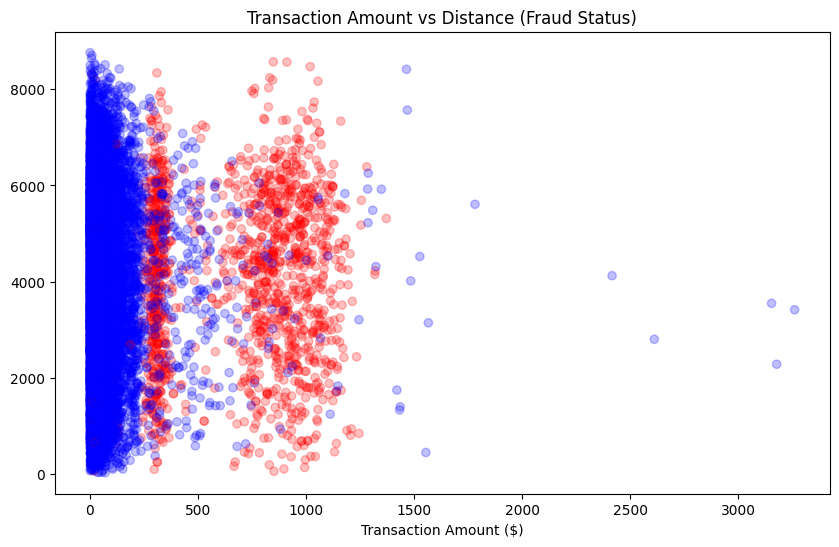

In [29]:
amt_data = data['amt']
dist_data = data['distance']

colors = ['red' if val > 0.5 else 'blue' for val in y]

plt.figure(figsize=(10,6))
plt.scatter(amt_data, dist_data, c=colors, alpha=.25)

plt.xlabel('Transaction Amount ($)')
# plt.ylabel('Fraud Indicator (isFraud)') what
plt.title('Transaction Amount vs Distance (Fraud Status)')

plt.show()

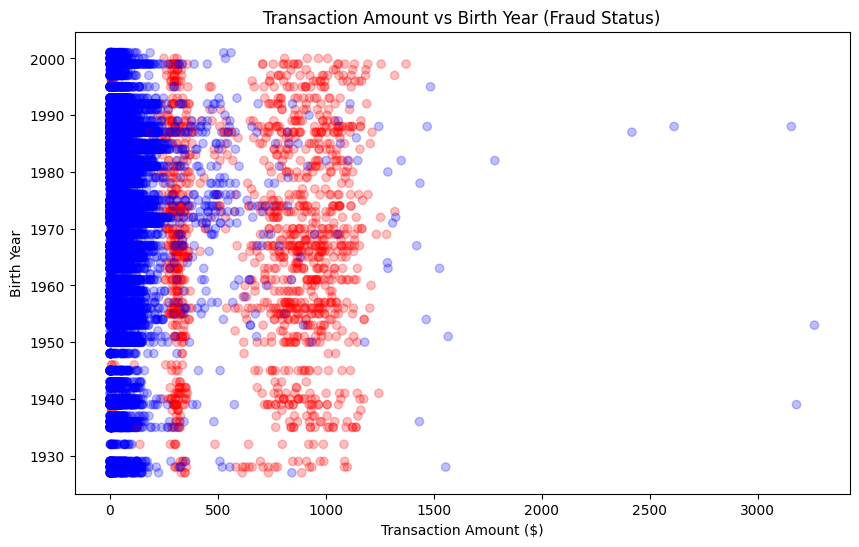

In [30]:
dob_data = data['dob_clean']

plt.figure(figsize=(10,6))
plt.scatter(amt_data, dob_data, c=colors, alpha=.25)

plt.xlabel('Transaction Amount ($)')
plt.ylabel('Birth Year')
plt.title('Transaction Amount vs Birth Year (Fraud Status)')

plt.show()

### KNN Approach

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [32]:
risk_data = data['high_risk']

features = ['amt', 'dist', 'high_risk', 'dob']

model_data = pd.DataFrame(np.column_stack((amt_data, dist_data, risk_data, dob_data, y)))
model_data.columns = ['amt', 'dist', 'high_risk', 'dob', 'is_fraud']
model_data = model_data.reset_index(drop = True)

model_data.head()

,amt,dist,high_risk,dob,is_fraud
0,14.37,6777.551807,0.0,1939.0,1.0
1,966.11,4602.142188,1.0,1939.0,1.0
2,49.61,3864.450222,0.0,1939.0,1.0
3,295.26,2003.511563,1.0,1939.0,1.0
4,18.17,4480.546886,0.0,1939.0,1.0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(model_data[['amt', 'dist', 'high_risk', 'dob']].values,
                                                     model_data['is_fraud'].values, test_size=.2, random_state=RANDOM_STATE,
                                                     stratify=model_data['is_fraud'])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11555, 4) (2889, 4) (11555,) (2889,)


In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=21)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print(f'Model has {acc:.4f}% accuracy!')

Model has 0.9218% accuracy!


### Random Forest Approach
The goal for doing this approach is to get a better understanding of the impact of our features on the final prediction. This will allow us to better refine which features we use in other potential models.

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
forest_clf = RandomForestClassifier(random_state=RANDOM_STATE)
forest_clf.fit(X_train, y_train)

y_pred_forest_skl = forest_clf.predict(X_test)
accuracy_forest = accuracy_score(y_test, y_pred_forest_skl)


print(f'Random Forest has {accuracy_forest:.4f}% accuracy!')

Random Forest has 0.9519% accuracy!


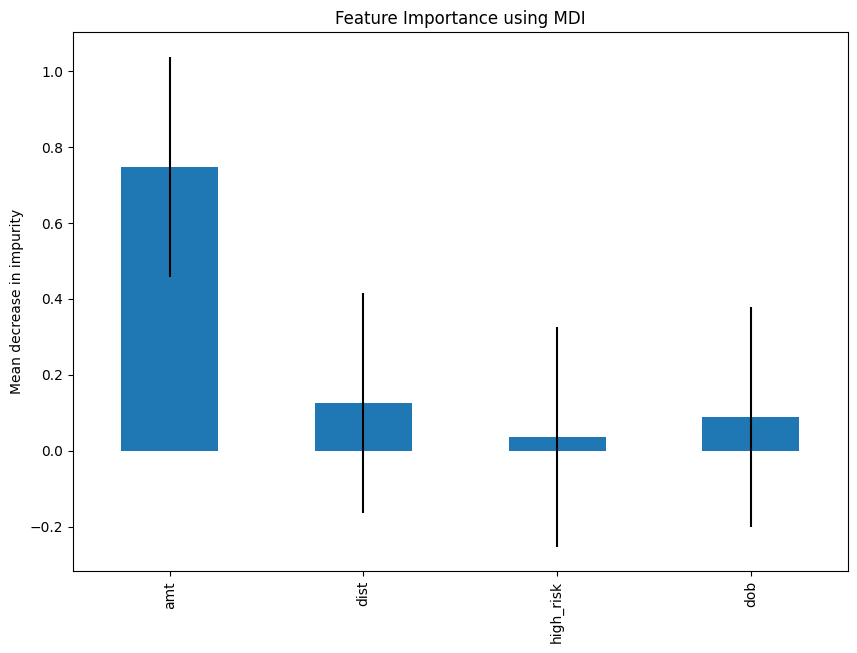

In [37]:
std_importance = np.std([tree.feature_importances_ for tree in forest_clf])

forest_importances = pd.Series(forest_clf.feature_importances_, index=features)

fig = plt.figure(figsize=(10,7))

forest_importances.plot.bar(yerr=std_importance)

fig.tight_layout
plt.title('Feature Importance using MDI')
plt.ylabel('Mean decrease in impurity')
plt.show()

This analysis shows us that our features dist, high_risk, and dob may sometimes increase our impurity, perhaps showing a very low correlation between fraud and these features.

In [48]:
import pandas as pd
import numpy as np

class FraudDataPreprocessor:
    def __init__(self, url):
        """
        Initialize the preprocessor with the data URL.
        """
        self.url = url
        self.data = None
        self.categories = None
        self.risk_table = None

    def load_data(self):
        """
        Load data from the provided URL.
        """
        self.data = pd.read_csv(self.url)
        self.data['is_fraud'] = self.data['is_fraud'].astype(str)  # Ensure consistency for filtering
        return self

    def clean_data(self):
        """
        Clean the data by removing incorrectly formatted rows in 'is_fraud'.
        """
        y = self.data['is_fraud']
        err_y = [y.unique()[1], y.unique()[3]]  # Identify incorrect formatting
        self.data = self.data[~self.data['is_fraud'].isin(err_y)].reset_index(drop=True)
        self.data['is_fraud'] = self.data['is_fraud'].astype(int)
        return self

    def add_dob_clean(self):
        """
        Add a cleaned 'dob_clean' column by extracting the year from the 'dob' field.
        """
        # Ensure dob exists before processing
        if 'dob' in self.data.columns:
            self.data['dob_clean'] = self.data['dob'].str[-4:].astype(int)  # Extract year from dob
        else:
            raise KeyError("The 'dob' column is missing in the data.")
        return self

    def calculate_distance(self):
        """
        Add a 'distance' column using the Haversine formula to calculate the distance
        between the consumer and the merchant.
        """
        if 'merch_lat' in self.data.columns and 'lat' in self.data.columns and 'merch_long' in self.data.columns and 'long' in self.data.columns:
            R = 6371  # Earth's radius in kilometers
            lat_diff = np.radians(self.data['merch_lat'] - self.data['lat'])
            long_diff = np.radians(self.data['merch_long'] - self.data['long'])
            lat1 = np.radians(self.data['lat'])
            lat2 = np.radians(self.data['merch_lat'])

            # Haversine formula
            a = np.sin(lat_diff / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_diff / 2)**2
            self.data['distance'] = 2 * R * np.arcsin(np.sqrt(a))
        else:
            raise KeyError("Latitude or Longitude columns are missing.")
        return self

    def encode_high_risk(self):
        """
        Encode the 'high_risk' feature based on fraud proportion thresholds for categories.
        """
        if 'category' in self.data.columns:
            # Calculate fraud proportions by category
            fraud_prop_by_cat = self.data.groupby('category')['is_fraud'].mean()
            self.categories = fraud_prop_by_cat.index
            high_risk_threshold = np.mean(fraud_prop_by_cat)

            # Encode categories as high or low risk
            risk_encoded = np.where(fraud_prop_by_cat > high_risk_threshold, 1, 0)
            self.risk_table = dict(zip(self.categories, risk_encoded))

            # Map the encoded risk values to the data
            self.data['high_risk'] = self.data['category'].map(self.risk_table)
        else:
            raise KeyError("The 'category' column is missing.")
        return self

    def preprocess(self):
        """
        Execute all preprocessing steps in sequence.
        """
        return (
            self.load_data()
                .clean_data()
                .add_dob_clean()
                .calculate_distance()
                .encode_high_risk()
                .data
        )


In [46]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import shap
import numpy as np
import pandas as pd

class FraudDetectionPipeline:
    def __init__(self, data, features, target):
        """
        Initialize the pipeline with data, features, and the target column.
        """
        self.data = data
        self.features = features
        self.target = target
        self.model = None
        self.scaler = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def preprocess(self):
        """
        Preprocess the data, including feature scaling and train-test splitting.
        """
        # Normalize features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(self.data[self.features])
        y = self.data[self.target].astype(int)

        # Train-test split
        RANDOM_STATE = 42
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        print("Data preprocessing completed.")

    @staticmethod
    def evaluate_model(y_test, y_pred, y_pred_proba):
        """
        Evaluate the model performance using multiple metrics.
        """
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred):.4f}")
        print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
        print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

    def train_baseline_model(self):
        """
        Train a baseline XGBoost model and evaluate its performance.
        """
        xgb_baseline = XGBClassifier(device='cuda', tree_method='hist', random_state=42)
        xgb_baseline.fit(self.X_train, self.y_train)
        y_pred_xgb = xgb_baseline.predict(self.X_test)
        y_pred_proba_xgb = xgb_baseline.predict_proba(self.X_test)[:, 1]
        print("Baseline XGBoost Performance:")
        self.evaluate_model(self.y_test, y_pred_xgb, y_pred_proba_xgb)
        self.model = xgb_baseline  # Save the baseline model

    def hyperparameter_tuning(self):
        """
        Perform hyperparameter tuning using RandomizedSearchCV.
        """
        param_dist = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
        xgb = XGBClassifier(device='cuda', tree_method='hist', random_state=42)
        random_search = RandomizedSearchCV(
            xgb, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42
        )
        random_search.fit(self.X_train, self.y_train)
        print("Best Hyperparameters:", random_search.best_params_)
        self.model = random_search.best_estimator_  # Save the optimized model

    def evaluate_optimized_model(self):
        """
        Evaluate the performance of the optimized model.
        """
        if self.model is None:
            print("No model found. Please train a model first.")
            return

        y_pred_optimized = self.model.predict(self.X_test)
        y_pred_proba_optimized = self.model.predict_proba(self.X_test)[:, 1]
        print("Optimized XGBoost Performance:")
        self.evaluate_model(self.y_test, y_pred_optimized, y_pred_proba_optimized)

    def explain_model(self):
        """
        Use SHAP to explain the model's predictions.
        """
        if self.model is None:
            print("No model found. Please train a model first.")
            return

        print("Explaining model using SHAP...")
        explainer = shap.Explainer(self.model)
        shap_values = explainer(self.X_train)
        shap.summary_plot(shap_values.values, self.X_train, feature_names=self.features)

In [50]:
# Example usage:
url = 'https://raw.githubusercontent.com/BlakeMilstead/FraudBot/refs/heads/main/fraud_data.csv'
preprocessor = FraudDataPreprocessor(url)
processed_data = preprocessor.preprocess()

print(processed_data.head())

pipeline = FraudDetectionPipeline(processed_data, features, target='is_fraud')
pipeline.preprocess()
pipeline.train_baseline_model()
pipeline.hyperparameter_tuning()
pipeline.evaluate_optimized_model()
pipeline.explain_model()

  trans_date_trans_time                          merchant        category  \
0      04-01-2019 00:58  "Stokes, Christiansen and Sipes"     grocery_net   
1      04-01-2019 15:06                      Predovic Inc    shopping_net   
2      04-01-2019 22:37                   Wisozk and Sons        misc_pos   
3      04-01-2019 23:06                    Murray-Smitham     grocery_pos   
4      04-01-2019 23:59                        Friesen Lt  health_fitness   

      amt   city state      lat      long  city_pop  \
0   14.37  Wales    AK  64.7556 -165.6723       145   
1  966.11  Wales    AK  64.7556 -165.6723       145   
2   49.61  Wales    AK  64.7556 -165.6723       145   
3  295.26  Wales    AK  64.7556 -165.6723       145   
4   18.17  Wales    AK  64.7556 -165.6723       145   

                          job         dob                         trans_num  \
0  "Administrator, education"  09-11-1939  a3806e984cec6ac0096d8184c64ad3a1   
1  "Administrator, education"  09-11-1939  a5918

KeyboardInterrupt: 